# Differential Expression Gene Analysis


### Init

In [1]:
# load libraryies
library("DESeq2")
library(ggplot2)
options(width=150) # increase the width of the screen output
library(EnhancedVolcano)




Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading required p

### Original Dataset - DEG of CTRL vs. BD

In [2]:
dds <- readRDS("dds_batch_diagnosis_original.rds")
res <- results(dds, contrast=c("diagnosis","ctrl","BD"))
summary(res)


out of 30976 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 61, 0.2%
LFC < 0 (down)     : 50, 0.16%
outliers [1]       : 36, 0.12%
low counts [2]     : 12424, 40%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [3]:
dds

class: DESeqDataSet 
dim: 39397 46 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(39397): 5S_rRNA 5_8S_rRNA ... hsa-mir-423 snoZ196
rowData names(31): baseMean baseVar ... maxCooks replace
colnames(46): X_R24834A_2 X_R24834A_1 ... X_R25549B_1 X_R29425B_1
colData names(8): batch diagnosis ... sizeFactor replaceable

In [4]:
# export deseq2 analysis results to csv file
write.csv(as.data.frame(res), file="original_dataset_CTRL_vs_BD_results.csv")

In [5]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 1 (i.e., at least double or half the level of expression)
res05 <- res[which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2)), ]

# sort by padj and write to file
res05Ordered <- res05[order(res05$padj),]
write.csv(as.data.frame(res05Ordered), file="original_dataset_CTRL_vs_BD_fdr05_fc2_results.csv")

### Filter and sorting results by p-Adj

In [6]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]

In [7]:
res[res_idx_05,]

log2 fold change (MLE): diagnosis ctrl vs BD 
Wald test p-value: diagnosis ctrl vs BD 
DataFrame with 46 rows and 6 columns
            baseMean log2FoldChange     lfcSE      stat      pvalue        padj
           <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
IGHEP1      22.37739       -3.74313  0.715473  -5.23169 1.67969e-07 4.44349e-04
ADAM23     290.20638       -3.73511  0.683450  -5.46509 4.62682e-08 2.14199e-04
PPP4R4      11.29782       -2.92903  0.692376  -4.23041 2.33271e-05 1.34991e-02
GNAQ         5.96316       -2.76629  0.734025  -3.76866 1.64127e-04 4.93616e-02
FRG1EP      16.78382       -2.32909  0.402835  -5.78175 7.39297e-09 4.56343e-05
...              ...            ...       ...       ...         ...         ...
IGHV1-24  2463.58988        5.88839   1.12347   5.24124 1.59498e-07 4.44349e-04
IGKV1-9    129.47916        6.94608   1.29382   5.36867 7.93212e-08 2.93774e-04
IGKV2D-29 2783.24182        7.81240   1.86332   4.19274 2.75606e-05 1.50108e

### VST regularization

In [8]:
vsd <- vst(dds, blind = TRUE)

In [9]:
# export vsd and count matrix log2FoldChange > 1 
# this will be use for ML (predictor)
res_idx_01 <- which(abs(res$log2FoldChange)>1)
length(res_idx_01)

write.csv(as.data.frame(assay(vsd)[res_idx_01,]), file="original_dataset_CTRL_vs_BD_vsd_results_FC1.csv")
write.csv(as.data.frame(counts(dds)[res_idx_01,]), file="original_dataset_CTRL_vs_BD_counts_results_FC1.csv")


[1] 1362

### PCA before batch - correction

In [10]:

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("diagnosis", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg1 = ggplot(pcaData, aes(PC1, PC2, color=diagnosis, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

ggplot2::ggsave("original_dataset_CTRL_vs_BD PCA before batch correction.eps", plot = gg1)



Saving 6.67 x 6.67 in image



### PCA after batch - correction

In [11]:


assay(vsd) <- limma::removeBatchEffect(assay(vsd), vsd$batch)
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("diagnosis", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg2 =  ggplot(pcaData, aes(PC1, PC2, color=diagnosis, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()
ggplot2::ggsave("original_dataset_CTRL_vs_BD PCA after batch correction.eps", plot = gg2)



Saving 6.67 x 6.67 in image



### Heatmap

In [12]:
df <- as.data.frame(colData(dds)[,c("diagnosis", "batch")])
rownames(df)<- rownames(colData(dds))
colnames(df) <- c("diagnosis", 'Batch')

#### Order by log2FoldChange

Saving 6.67 x 6.67 in image



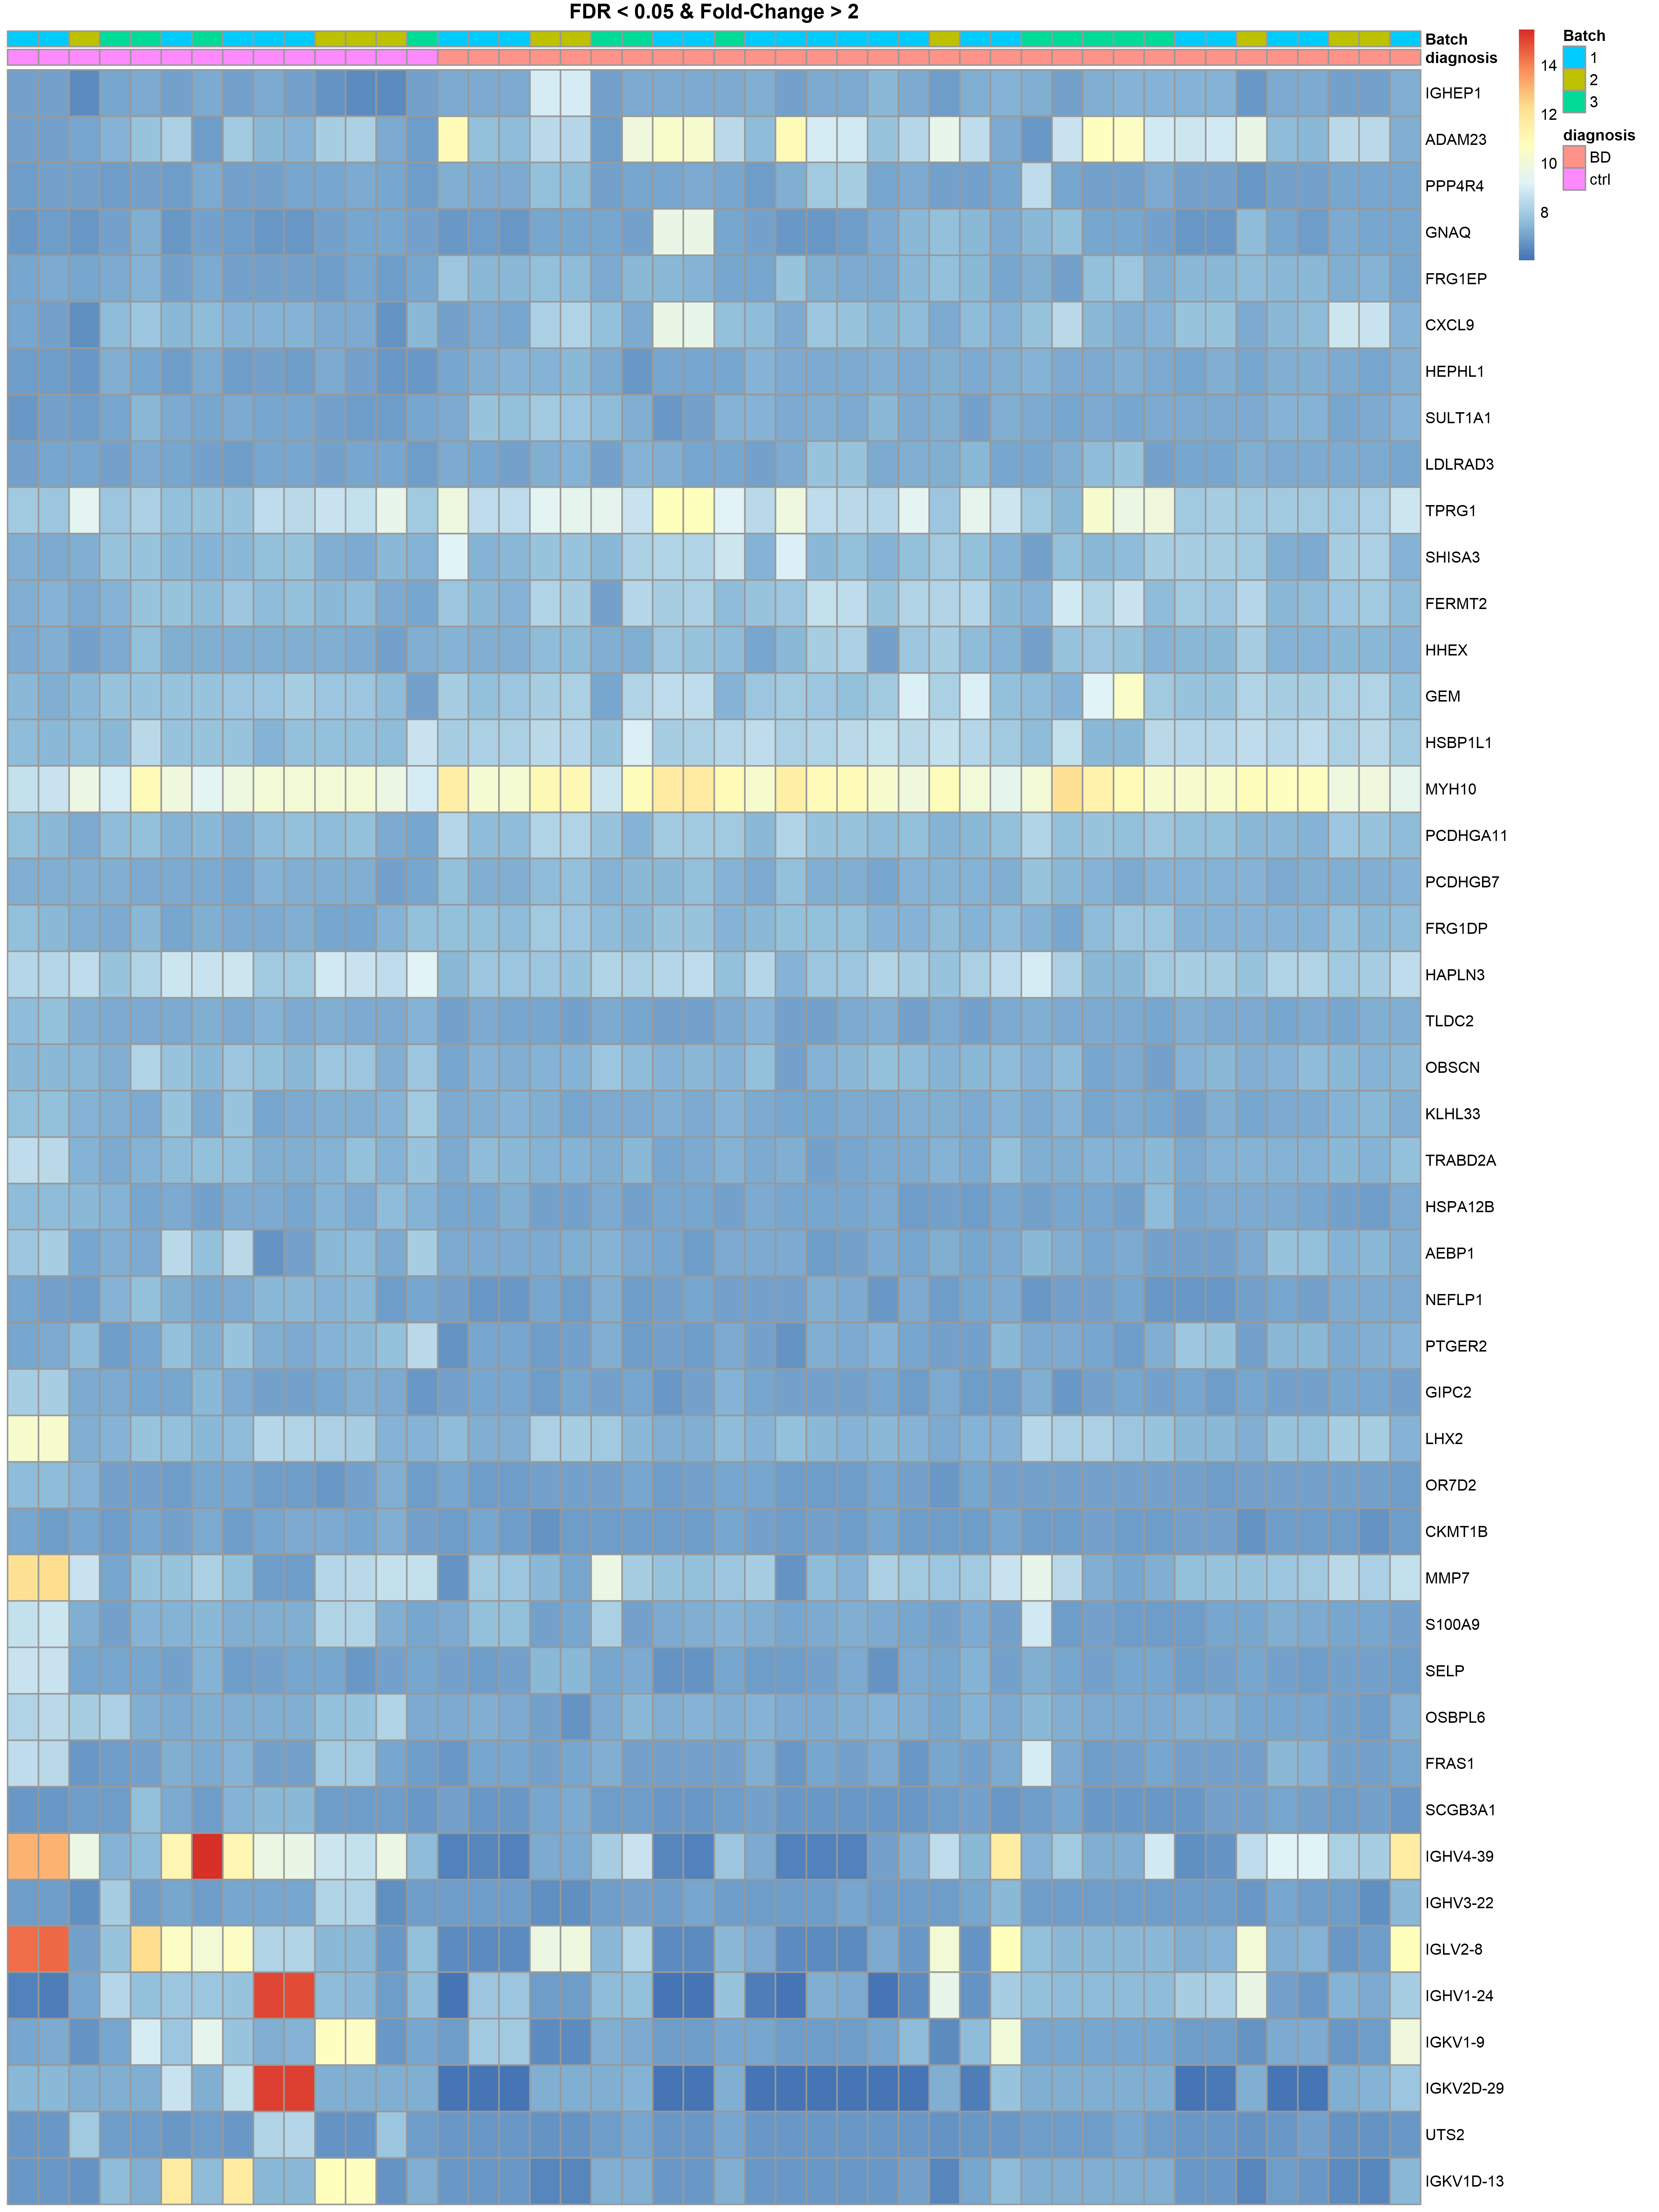

In [13]:

# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]



options(repr.plot.width = 15, repr.plot.height = 20, repr.plot.res = 300)
library(pheatmap)
gg3= pheatmap(assay(vsd)[res_idx_05,], 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         display_numbers = FALSE, 
         annotation_col = df,
         main = "FDR < 0.05 & Fold-Change > 2")

ggplot2::ggsave("original_dataset_CTRL_vs_BD heatmap.eps", plot = gg3)


### Volcano Plot

In [14]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 300)
gg4 = EnhancedVolcano(res,
                lab = rownames(res),
                #selectLab = rownames(res[res_idx_05,]),
                x = 'log2FoldChange',
                y = 'pvalue', 
                pCutoffCol = 'padj',
                pCutoff = 0.05,
                FCcutoff = 1,
                ylim = c(0, -log10(10e-9)),
                xlim = c(-7, 10),
                pointSize = c(ifelse(res$padj<0.05 & abs(res$log2FoldChange)>log2(2), 1.5, 0.75)), 
                labSize = 2.0, 
                title = 'CTRL vs BD',
                subtitle = 'Differential expression',
                caption = 'FC cutoff, 2.0; p-adj cutoff, 0.05',
                colAlpha = 1.0, 
                legendPosition = "top",
                legendLabSize = 10,
                legendIconSize = 2, 
                legendLabels = c("NS", expression(Log[2] ~ FC), "p-Adj", expression(P-adj ~ "&" ~ log[2] ~ FC)),
               )
ggplot2::ggsave("original_dataset_CTRL_vs_BD Volcano Plot - padj.eps", plot = gg4)

Saving 6.67 x 6.67 in image



In [15]:
pdf()

### plotCounts

#### FDR (padj) < 0.05 & Fold-change > 2.0 

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res =200)

res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]


pdf("original_dataset_CTRL_vs_BD plotCounts.pdf", width = 16 , height = 10, title = "plotCounts : CTRL_vs_BD ")
gg5 = attach(mtcars)
par(mfrow=c(4,4))
for (gene in rownames(res[res_idx_05,])) {
    plotCounts(dds, gene=gene, intgroup="diagnosis")
    }

dev.off()

The following object is masked from package:ggplot2:

    mpg




png 
  2

=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================

In [17]:
pdf("sessionInfo.pdf", width = 16 , height = 10, title = "plotCounts : CTRL_vs_BD ")
sessionInfo()
dev.off()

R version 4.1.1 (2021-08-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18363)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252  LC_CTYPE=English_United States.1252    LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                           LC_TIME=English_United States.1252    

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12             EnhancedVolcano_1.12.0      ggrepel_0.9.1               ggplot2_3.3.5               DESeq2_1.34.0              
 [6] SummarizedExperiment_1.24.0 Biobase_2.54.0              MatrixGenerics_1.6.0        matrixStats_0.61.0          GenomicRanges_1.46.0       
[11] GenomeInfoDb_1.30.0         IRanges_2.28.0              S4Vectors_0.32.2            BiocGenerics_0.40.0        

loaded via a namespace (and not attached):
 [1] bitops_1.0-7           bit64_4.0.5            ash_1.0-15

png 
  2